In [1]:
from sklearn.datasets import make_swiss_roll, make_moons
from matplotlib import pyplot as plt
from genexp.models import DiffusionModel

from tqdm import tqdm
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.loggers.tensorboard import TensorBoardLogger

from genexp.sampling import VPSDE, sample_trajectories_ddpm, sample_trajectories_memoryless, EMDiffusionSampler, DDIMSampler, EulerMaruyamaSampler, MemorylessSampler
from genexp.trainers.adjoint_matching import AMTrainerFlow
from genexp.trainers.genexp import FDCTrainerFlow

from matplotlib.widgets import Button, Slider

2025-12-03 16:09:11.770081: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-03 16:09:11.799350: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-03 16:09:11.799390: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-03 16:09:11.800416: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-03 16:09:11.806315: I tensorflow/core/platform/cpu_feature_guar

In [2]:
class LightningDiffusion(LightningModule):
    def __init__(self, model: DiffusionModel):
        super().__init__()
        self.model = model

    
    def forward(self, *args, **kwargs):
        return self.model(*args, **kwargs)
    

    def training_step(self, batch, batch_idx):
        x0, = batch
        t = torch.rand(x0.shape[0]).to(x0.device)
        alpha, sig = self.model.sde.get_alpha_sigma(t[:, None])
        eps = torch.randn(x0.shape).to(x0.device)

        xt = torch.sqrt(alpha) * x0 + sig * eps

        eps_pred = self(xt, t[:, None])

        loss = torch.mean((eps - eps_pred)**2) / 2.
        self.log('loss', loss, prog_bar=True)
        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

## Training base model

In [17]:
x0 = torch.randn((50000, 2))
x1 = torch.randn((5000, 2)) * 0.3 + 3
dataset = torch.vstack((x0, x1))

network = nn.Sequential(
    nn.Linear(3, 512),
    nn.ReLU(),
    nn.Linear(512, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 2)
)

sde = VPSDE(0.1, 12)

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
model = DiffusionModel(network, sde).to(device)
pl_model = LightningDiffusion(model)


dl = DataLoader(TensorDataset(dataset), batch_size=128, shuffle=True)

trainer = Trainer(max_epochs=10)
trainer.fit(pl_model, dl)
torch.save(model.model.state_dict(), 'gauss_model.pth')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type           | Params | Mode 
-------------------------------------------------
0 | model | DiffusionModel | 396 K  | train
-------------------------------------------------
396 K     Trainable params
0         Non-trainable params
396 K     Total params
1.586     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

/cluster/software/stacks/2024-06/spack/opt/spack/linux-ubuntu22.04-x86_64_v3/gcc-12.2.0/python-3.9.18-djnolup5uvd3ftcqzbfbfsc5b5lfls3b/lib/python3.9/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


## Loading base model

In [20]:
x0 = torch.randn((50000, 2))
x1 = torch.randn((5000, 2)) * 0.3 + 3
dataset = torch.vstack((x0, x1))

network = nn.Sequential(
    nn.Linear(3, 512),
    nn.ReLU(),
    nn.Linear(512, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 2)
)

sde = VPSDE(0.1, 12)

model = DiffusionModel(network, sde)
pl_model = LightningDiffusion(model)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.model.load_state_dict(torch.load('gauss_model.pth'))
sampler = EulerMaruyamaSampler(model.to(device), data_shape=(2,), device=device)

samples = []
for i in range(50000 // 128):
    trajs, ts = sampler.sample_trajectories(N=8192, T=1000, device=device)
    samples.append(trajs[-1].full.detach().cpu())

samples = torch.vstack(samples)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].hist(dataset[:, 0], bins=150)
ax[1].hist(samples[:, 0].detach().cpu(), bins=100)
ax[0].set_title('Data density')
ax[1].set_title('Pretrained model density')
plt.show()

OutOfMemoryError: CUDA out of memory. Tried to allocate 16.00 MiB. GPU 

In [10]:
from omegaconf import OmegaConf
import copy

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
config = OmegaConf.load('../configs/example_fdc.yaml')
sampler = EulerMaruyamaSampler(model, data_shape=(2,), device=device)
model = model.to(device)
fdc_trainer = FDCTrainerFlow(config, copy.deepcopy(model), copy.deepcopy(model), device=device, sampler=sampler)

In [11]:
for k in tqdm(range(config.num_md_iterations)):
    for i in range(config.adjoint_matching.num_iterations):
        am_dataset = fdc_trainer.generate_dataset()
        fdc_trainer.finetune(am_dataset, steps=config.adjoint_matching.finetune_steps)

    fdc_trainer.update_base_model()

100%|██████████| 3/3 [00:51<00:00, 17.33s/it]


TypeError: '<' not supported between instances of 'tuple' and 'int'

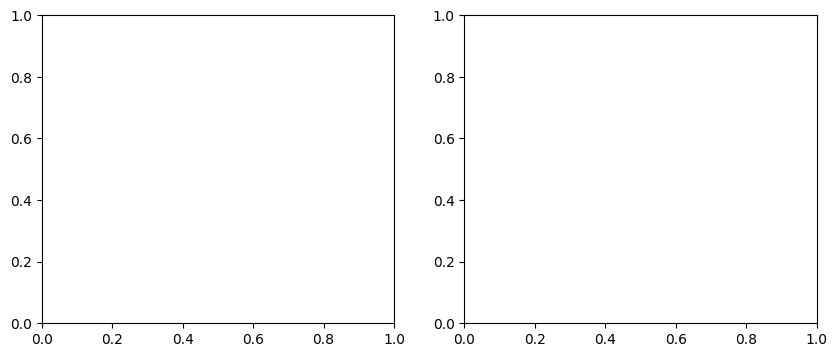

In [12]:
sampler = EulerMaruyamaSampler(fdc_trainer.fine_model.to(device), data_shape=(2,), device=device)

samples_fdc = []
for i in range(50000 // 128):
    trajs, ts = sampler.sample_trajectories(N=128, T=1000, device=device)
    samples_fdc.append(trajs[-1].full.detach().cpu())

samples_fdc = torch.vstack(samples_fdc)

fig, ax = plt.subplots(1, 3, figsize=(10, 4))
ax[0].hist(dataset[:, 0], bins=150)
ax[1].hist(samples_fdc[:, 0].detach().cpu(), bins=150)
ax[0].set_title('Data density')
ax[1].set_title('Fine-tuned model density')
plt.show()